In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Xopt class, TNK test function

This is the class method for running Xopt. Use Bayesian exploration to explore the input space.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [2]:
# Import the class
from xopt import Xopt

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null, verbose: true}

algorithm:
  name: bayesian_exploration
  options: {n_initial_samples: 5,
            use_gpu: False,
            #restart_data_file: results.json, ## You can use a restart file if you want to
            n_steps: 20, 
            verbose: True}
  
simulation: 
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK  
  
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: ['LESS_THAN', 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

In [4]:
X = Xopt(config)
X

Loading config as dict.



            Xopt 
________________________________           
Version: 0.4.3
Configured: True
Config as YAML:
xopt: {output_path: null, verbose: true}
algorithm:
  name: bayesian_exploration
  function: xopt.bayesian_exploration.bayesian_exploration
  options: {n_initial_samples: 5, use_gpu: false, n_steps: 20, verbose: true}
simulation:
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK
  options: {extra_option: abc}
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

# Run BayesOpt

In [5]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

executor = PoolExecutor()
# This will also work. 
#executor=None

In [6]:
# Change max generations
X.run(executor=executor)

Starting at time 2021-08-09T12:22:01-05:00
No executor given. Running in serial mode.
Candidate(s): tensor([[0.4493, 0.2355]], dtype=torch.float64)
Candidate(s): tensor([[0.0000, 1.4170]], dtype=torch.float64)
Candidate(s): tensor([[1.2603, 0.0000]], dtype=torch.float64)
Candidate(s): tensor([[0.7116, 1.0732]], dtype=torch.float64)
Candidate(s): tensor([[0.4638, 1.0329]], dtype=torch.float64)
Candidate(s): tensor([[0.9490, 0.6482]], dtype=torch.float64)
Candidate(s): tensor([[1.0487, 0.3157]], dtype=torch.float64)
Candidate(s): tensor([[0.2990, 1.1013]], dtype=torch.float64)
Candidate(s): tensor([[0.1580, 1.0348]], dtype=torch.float64)
Candidate(s): tensor([[0.0153, 0.9615]], dtype=torch.float64)
Candidate(s): tensor([[0.9929, 0.9276]], dtype=torch.float64)
Candidate(s): tensor([[1.0641, 0.1411]], dtype=torch.float64)
Candidate(s): tensor([[1.1766, 0.6330]], dtype=torch.float64)
Candidate(s): tensor([[0.7285, 0.7677]], dtype=torch.float64)
Candidate(s): tensor([[0.5221, 1.1802]], dtype

# Plot
- plot input space samples -> yellow points satisfy constraints and purple points do not

dict_keys(['variables', 'objectives', 'constraints', 'constraint_status', 'feasibility', 'model'])


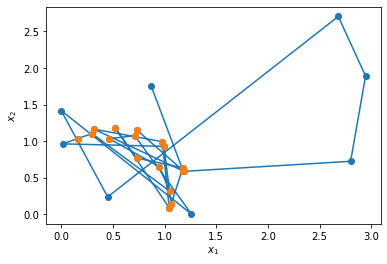

In [9]:


import matplotlib.pyplot as plt
%matplotlib inline

# plot exploration results and path - exploration should explore the feasible region of the TNK problem - See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf
fig, ax = plt.subplots()

results = X.results
print(results.keys())
variables = results['variables']
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o')
ax.plot(valid[:, 0], valid[:, 1], 'o')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()